## Hybrid DNN Recommendation Engine
- Check out: https://github.com/NicolasHug/Surprise

- In this example, we will explore building a DNN hybrid model using bot user/item embeddings along with  metadata in order to predict ratings. The scenario is given a dataset of users and courses they've viewed, recommend other courses a user may also be interested in. This example is basically a regression problem where we try to predict the ratings for each user and then recommend the highest predicted ratings. 

In [1]:
%cd ..

/Users/tracesmith/Desktop/Trace/Coding/user-recommender


In [327]:
%load_ext autoreload
%autoreload
import os
import numpy as np
import pandas as pd
from typing import List
import tensorflow as tf
from tqdm import tqdm
from recommenders.utils.plots import plot_metrics
from sklearn.feature_extraction.text import TfidfVectorizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Prepare Dataset

In [356]:
# Courses
items = pd.read_csv(os.path.join('data','course_tags.csv'))
items = items.rename(columns={'course_id':'item_id'})
items['item_id'] = items['item_id'].apply(lambda x: ' '.join(x.split('-')))
                              
# Users
users = pd.read_csv(os.path.join('data','user_course_views.csv'))
users = users.rename(columns={'user_handle':'user_id',
                              'course_id':'item_id',
                              'view_time_seconds':'view_time'})
users['item_id'] = items['item_id'].apply(lambda x: ' '.join(x.split('-')))

# Aggregate user viewing time --> viewed same course multiple times
users = users.groupby(['user_id','item_id','level'])['view_time'].sum().reset_index(drop=False)

### Unique User/Items

In [357]:
unique_users = users['user_id'].unique()
unique_items = items['item_id'].unique()
print(unique_users.shape[0],unique_items.shape[0])

393 5942


### Mappings for User/Items

In [330]:
# User Mappings
users_map = {i:val for i,val in enumerate(unique_users)}
users_inverse_map = {val:i for i,val in enumerate(unique_users)}

# Item Mappings
items_map = {i:val for i,val in enumerate(unique_items)}
items_inverse_map = {val:i for i,val in enumerate(unique_items)}

# Level Mappings
levels_map= {'Beginner':0, 'Advanced':1, 'Intermediate':2}

In [331]:
users['user_id_encoded'] = users['user_id'].map(users_inverse_map)
users['item_id_encoded'] = users['item_id'].map(items_inverse_map)
users['level_encoded'] = users['level'].map(levels_map)
items['item_id_encoded'] = items['item_id'].map(items_inverse_map)

### Create Features

### Side Features

- Let's additional side features to help improve the model. 
- First we can use the titles and convert into tfidf features.

In [332]:
# TFIDF Features
tfidf = TfidfVectorizer(max_features=25,stop_words='english')
tfidf_hybrid = tfidf.fit_transform(ratings['item_id'])
users['tfidf'] = tfidf_hybrid.toarray().tolist()

In [318]:
# Format vector
users['tfidf'] = users['tfidf'].apply(lambda x: np.array(x))

### Create Explicit Data

In [319]:
ratings = users.copy()
ratings['rating'] = [np.random.randint(1,5) for i in range(ratings.shape[0])]

### Train/Test Split

In [320]:
def split_train_test(data:pd.DataFrame, split_ratio:float) -> np.ndarray:
    """ Split Train/Test Dataset"""
    idx = int(np.ceil(len(ratings) * split_ratio))
    train,test = data[:-idx], data[-idx:]
    print(f'Train Shape: {train.shape} -- Test Shape: {test.shape}')
    return train,test
    
train,test = split_train_test(ratings,split_ratio=0.20)

Train Shape: (6045, 9) -- Test Shape: (1512, 9)


_____
## Deep-Hybrid Recommendation System


In [334]:
%autoreload
from recommenders.hybrid import HybridRecommender
Hybrid = HybridRecommender(unique_users,
                           unique_items,
                           tfidf_features=train_tfidf,
                           epochs=10, 
                           dense_units=100,
                           dropout=0.20, 
                           batch_size=64,
                           embedding_dim=25)

In [349]:
%autoreload
history = Hybrid.train([train['user_id_encoded'],
                        train['item_id_encoded'],
                        np.stack(train['tfidf'],axis=0),
                        train['level_encoded']],
                        train['rating'])
model = Hybrid.model

Epoch 1/10
85/85 [==============================] - 2s 8ms/step - loss: 4.0046 - val_loss: 2.2203
Epoch 2/10
85/85 [==============================] - 0s 4ms/step - loss: 1.8927 - val_loss: 1.7613
Epoch 3/10
85/85 [==============================] - 1s 7ms/step - loss: 1.1399 - val_loss: 1.5801
Epoch 4/10
85/85 [==============================] - 0s 4ms/step - loss: 0.7925 - val_loss: 1.4825
Epoch 5/10
85/85 [==============================] - 0s 5ms/step - loss: 0.6447 - val_loss: 1.4190
Epoch 6/10
85/85 [==============================] - 0s 5ms/step - loss: 0.5702 - val_loss: 1.3779
Epoch 7/10
85/85 [==============================] - 0s 4ms/step - loss: 0.5125 - val_loss: 1.3448
Epoch 8/10
85/85 [==============================] - 0s 6ms/step - loss: 0.4773 - val_loss: 1.3238
Epoch 9/10
85/85 [==============================] - 0s 4ms/step - loss: 0.4592 - val_loss: 1.3106
Epoch 10/10
189/189 [==============================] - 0s 2ms/step - loss: 0.4481


2021-08-01 19:08:01,069 - recommenders.hybrid INFO - train mean squared error: 0.4481


### Evaluate Model

In [350]:
Hybrid._evaluate([test['user_id_encoded'],
                  test['item_id_encoded'], 
                  test_tfidf.toarray(),
                  test_levels], 
                  test['rating'],
                  name='test')

48/48 [==============================] - 0s 3ms/step - loss: 1.3178


2021-08-01 19:08:15,147 - recommenders.hybrid INFO - test mean squared error: 1.3178


### Model Summary

In [351]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
user (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 25)        148550      item[0][0]                       
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 25)        9825        user[0][0]                       
___________________________________________________________________________________________

/Users/tracesmith/Desktop/Trace/Coding/user-recommender/recommenders/utils/plots.py:22: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(n_rows, n_cols, idx + 1)


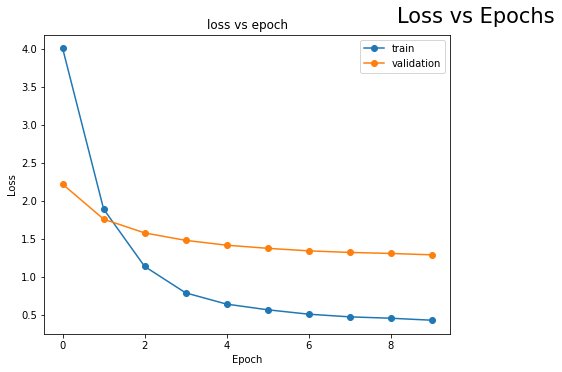

In [352]:
# %autoreload
plot_metrics(history,metrics=['loss'])

In [212]:
def get_recommendations(user_id:int,
    items:List[int],
    items_lookup:dict, 
    levels_lookup:dict,
    tfidf:np.ndarray,
    model:tf.keras.models.Model,
    topk:int=None):
    """
    Predict Ratings for given input user and return top recommended items 
    """
    user = np.array([user_id])
    predictions=[]
    for i in tqdm(items):
        item = np.array([i])
        level = np.array([i])
        tfidf_features = np.array([tfidf.transform([str(items_lookup[i])]).toarray().reshape(-1,1)])
        predictions.extend(model.predict([user,item,tfidf_features,level]).ravel())
    #generate rankings
    mappings = [items_lookup[i] for i in np.argsort(predictions)[:topk]]
    return mappings